In [1]:
import torch
import torch.nn as nn
import json
import numpy as np
from pathlib import Path
from distribution_inference.config import TrainConfig
from distribution_inference.datasets.utils import get_dataset_wrapper, get_dataset_information
import matplotlib.pyplot as plt
import scipy.stats as stats

/sfs/gpfs/tardis/home/ujx4ab/ondemand/dissecting_dist_inf/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load training configuration
config_path = Path('/sfs/gpfs/tardis/home/ujx4ab/ondemand/dissecting_dist_inf/experiments/configs/lstm_WT_new/train_models.json')
train_config = TrainConfig.load(config_path, drop_extra_fields=False)
data_config = train_config.data_config
misc_config = train_config.misc_config

In [3]:
data_config.split = 'victim'

In [4]:
data_config

DatasetConfig(name='lstm_WT_new', prop='WT_Energy_Availability', value=0.1, split='victim', drop_sensitive_cols=False, scale=1.0, augment=False, classify=None, cwise_samples=None, squeeze=False, processed_variant=True, prune=0, adv_use_frac=1.0, relation_config=None, WT_config=WTDatasetConfigs(download_data=True, adv_vic_data_overlap_ratio=0.0, train_test_data_overlap_ratio=0.0, turbines=None, training_timestamp_range=('2017-08-01',), exclude_fault_data=False, predicted_property=['Power'], dataset='Scotland'), feature_config={'EDP': FeatureConfig(rename={'Timestamp': 'Timestamp', 'Amb_WindSpeed_Avg': 'WindSpeed', 'Amb_WindSpeed_Std': 'WindSpeed_SD', 'Blds_PitchAngle_Avg': 'BladePitch', 'Blds_PitchAngle_Std': 'BladePitch_SD', 'Amb_Temp_Avg': 'AmbientTemp', 'Amb_WindDir_Relative_Avg': 'RelWindDir', 'Gen_RPM_Avg': 'GenSpeed', 'Gen_RPM_Std': 'GenSpeed_SD', 'Rtr_RPM_Avg': 'RotorSpeed', 'Rtr_RPM_Std': 'RotorSpeed_SD', 'Gen_Phase1_Temp_Avg': 'GenPhaseTemp1', 'Gen_Phase2_Temp_Avg': 'GenPhaseTe

In [5]:
# Instantiate dataset wrapper
ds_wrapper_class = get_dataset_wrapper(data_config.name)
ds_info_cls = get_dataset_information(data_config.name)

# Create dataset object
ds = ds_wrapper_class(
    data_config,
    epoch=train_config.save_every_epoch,
    skip_data=False,
    label_noise=train_config.label_noise
)

# Get test loader (held-out split)
_, test_loader = ds.get_loaders(batch_size=32)

Creating train/test splits.: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


Prop ratio: 0.1


In [6]:
test_loader.dataset.data.shape

torch.Size([75000, 145, 30])

In [7]:
# User-specified paths
checkpoint_path = Path('/sfs/gpfs/tardis/home/ujx4ab/ondemand/dissecting_dist_inf/models/lstm_wt_new/SimpleLSTM/normal/WT_Energy_Availability/victim/WTs_all/0.1/1_0.0010.ch')

# Build model architecture
if misc_config and misc_config.dp_config:
    model = ds_info_cls(train_config.save_every_epoch).get_model_for_dp(
        model_arch=train_config.model_arch
    )
else:
    ds_info = ds_info_cls(train_config.save_every_epoch)
    model = ds_info.get_model(model_arch=train_config.model_arch)

# Load checkpoint
state = torch.load(str(checkpoint_path), map_location='cpu')
model.load_state_dict(state)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

SimpleLSTM(
  (lstm): LSTM(30, 64, batch_first=True)
  (dropout): Identity()
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [8]:
it = iter(test_loader)
X, y, prop_labels = next(it)

In [9]:
criterion = nn.MSELoss()

all_preds    = []
all_targets  = []
all_props    = []

with torch.no_grad():
    for batch in test_loader:
        X, y, prop_labels = batch
        X = X.to(device)
        y = y.to(device).float().squeeze()
        prop_labels = prop_labels.to(device).squeeze()

        outputs = model(X)
        preds = outputs.view(-1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())
        all_props.append(prop_labels.cpu())

all_preds   = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy().squeeze()
all_props   = torch.cat(all_props).numpy()

mse = ((all_preds - all_targets)**2).mean()
print(f"Test MSE (overall): {mse:.6f}")

Test MSE (overall): 0.001021


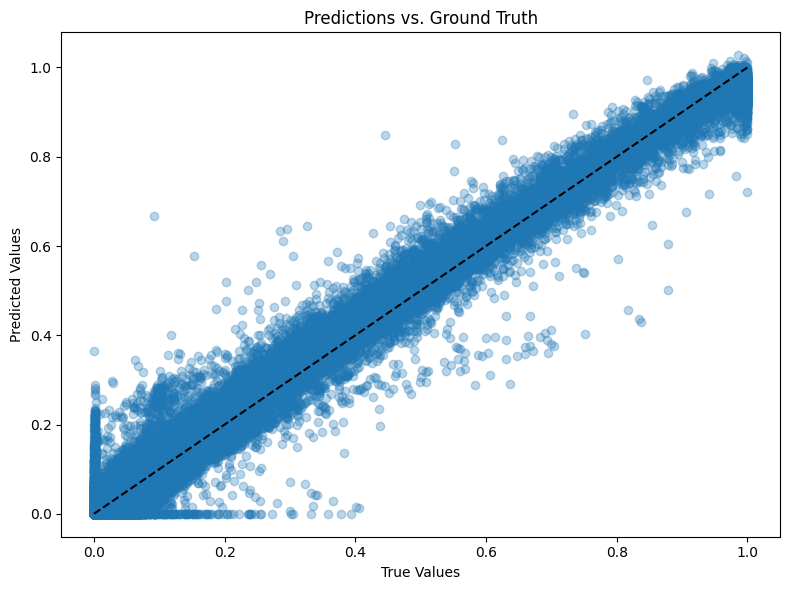

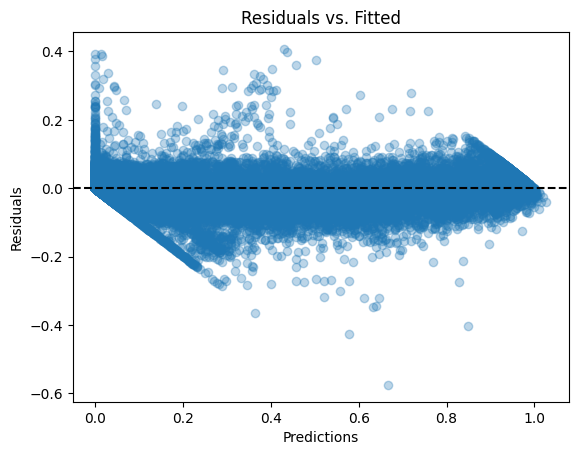

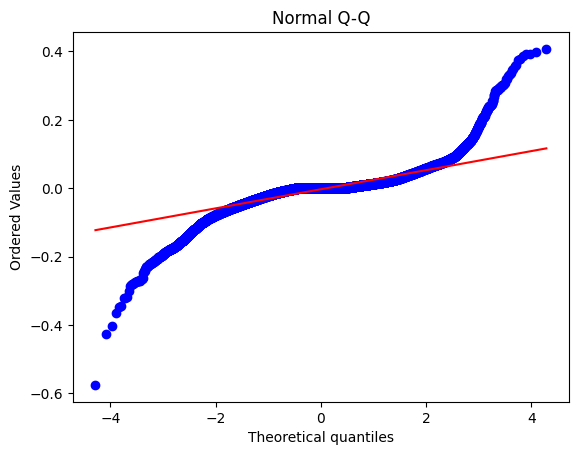

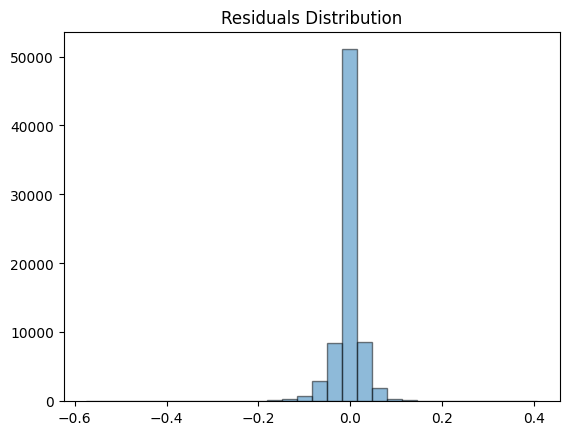

In [10]:
# Plot predictions vs. ground truth
plt.figure(figsize=(8, 6))
plt.scatter(all_targets, all_preds, alpha=0.3)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs. Ground Truth')
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'k--')
plt.tight_layout()
plt.show()

residuals = all_targets - all_preds

# 2) Residuals vs. Fitted
plt.figure()
plt.scatter(all_preds, residuals, alpha=0.3)
plt.axhline(0, linestyle='--', color='k')
plt.xlabel('Predictions'); plt.ylabel('Residuals'); plt.title('Residuals vs. Fitted')

# 3) Q-Q Plot
plt.figure()
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q')

# 4) Histogram of Residuals
plt.figure()
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.5)
plt.title('Residuals Distribution')

plt.show()
